In [108]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline #preprocessing 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve
from imblearn.pipeline import Pipeline as pipe #model processed data

In [126]:
pkl_path = 'cone_burnout_data.pkl'

In [127]:
df = pd.read_pickle(pkl_path)

In [131]:
df.head()

,employee_obj_id,clicks_count,patients_accessed_count,after_hours_count,value,indicator
0,119132,45109.0,751.0,446.0,GNA-GUILFORD NEUROLOGIC MAIN,0
1,119581,15991.0,443.0,375.0,LB-62930 VINCENT W RCK MADIS,0
2,119624,8401.0,207.0,106.0,WHG-PHYSICAL THERAPY,0
3,119634,90130.0,638.0,414.0,AAPC-ALAMANCE REG PAIN CLINIC,0
4,119728,24471.0,516.0,403.0,UMFMD-EVA SHAW MD,0


In [132]:
y_check = df['indicator']
y_check=y_check.astype('int')
print(y_check.value_counts())

0    726
1     61
Name: indicator, dtype: int64


In [133]:
train_df = df.sample(frac=0.7, random_state=1019)
test_df = df.drop(train_df.index)

In [134]:
true_y = train_df['indicator']
test_y = test_df['indicator']

In [135]:
true_y=true_y.astype('int')
test_y=test_y.astype('int')

In [136]:
train_X = train_df.drop(['employee_obj_id','indicator'],axis=1)
test_X = test_df.drop(['employee_obj_id','indicator'],axis=1)

In [137]:
train_X = train_X.rename({'patients_accessed_count': 'NUM_PATIENTS', 'value': 'DEPT', 
                          'clicks_count': 'CLICKS','after_hours_count': 'AFTER_HOURS'}, axis=1) 
test_X = test_X.rename({'patients_accessed_count': 'NUM_PATIENTS', 'value': 'DEPT',
                        'clicks_count': 'CLICKS','after_hours_count': 'AFTER_HOURS'}, axis=1) 

In [138]:
train_X.head()

,CLICKS,NUM_PATIENTS,AFTER_HOURS,DEPT
224,NaN,NaN,NaN,NaN
166,16302.0,781.0,516.0,DST-DR W SPENCER TILLEY PRACT
53,13215.0,682.0,545.0,BH-PHYSICIAN SERVICES
706,NaN,NaN,NaN,NaN
148,11554.0,77.0,66.0,MHC - DIV 4000 - IP REHAB


In [139]:
test_y.value_counts()

0    218
1     18
Name: indicator, dtype: int64

In [140]:
def transform_pipeline(categorical_features,numeric_features):
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])    
    
    ct = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])  
    
    return ct  

In [141]:
num_features = ['NUM_PATIENTS']
cat_features = ['DEPT']

In [142]:
ct = transform_pipeline(cat_features,num_features)

In [143]:
#apply the transform 
X_train_trans = ct.fit_transform(train_X)
X_test_trans = ct.transform(test_X)

In [153]:
def ml_pipeline():
    ss_step = ('ss', StandardScaler(with_mean=False))

    rfc_step = ('rfc',RandomForestClassifier())
    
    pipeline_steps = [ss_step, rfc_step]
    
    ml_pipe = pipe(pipeline_steps)
    
    return ml_pipe

In [154]:
ml_pipe = ml_pipeline()

In [155]:
#fit to train
ml_pipe.fit(X_train_trans,true_y)

Pipeline(steps=[('ss', StandardScaler(with_mean=False)),
                ('rfc', RandomForestClassifier())])

In [156]:
#predict on test
y_pred = ml_pipe.predict(X_test_trans)
y_prob = ml_pipe.predict_proba(X_test_trans)[:,1]

In [100]:
#metrics

In [157]:
scores = cross_val_score(ml_pipe, X_train_trans, true_y, cv=5)

In [158]:
scores

array([0.91891892, 0.92727273, 0.92727273, 0.91818182, 0.90909091])

In [159]:
cr = classification_report(test_y,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       218
           1       0.00      0.00      0.00        18

    accuracy                           0.92       236
   macro avg       0.46      0.50      0.48       236
weighted avg       0.85      0.92      0.88       236



In [160]:
cm = confusion_matrix(test_y,y_pred)
print(cm)

[[216   2]
 [ 18   0]]


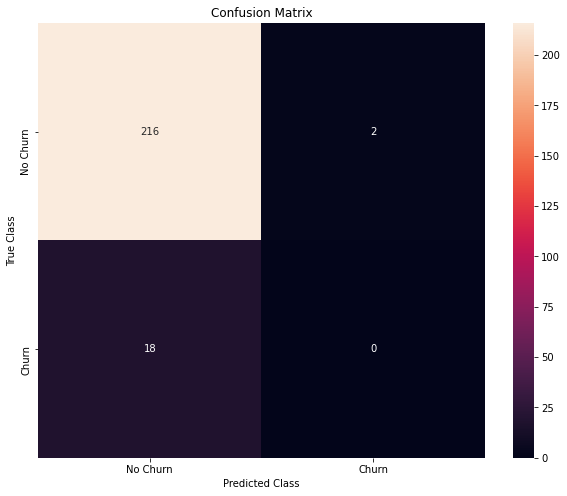

In [163]:
def plot_cm(cm):
    labels = ['No Churn','Churn']
    plt.figure(figsize=(10,8))
    sns.heatmap(cm,xticklabels=labels,yticklabels=labels,annot=True,fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show

plot_cm(cm)

In [164]:
fpr, tpr, thresholds = roc_curve(test_y,y_prob)
roc_auc = auc(fpr,tpr)

In [165]:
def plot_roc(fpr, tpr, thresholds,roc_auc):
    plt.figure(figsize=(15,8))
    plt.title('Receiver Operating Characteristic AUC')
    plt.plot(fpr,tpr,'b',label='AUC = %0.2f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

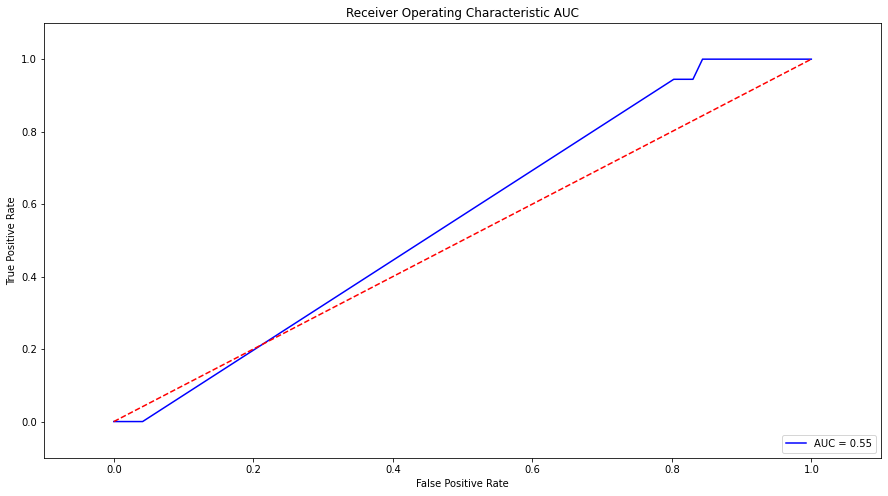

In [166]:
plot_roc(fpr, tpr, thresholds,roc_auc)